# Check The Ranking Quality

In [1]:
# standard imports
import numpy as np
import os

# plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# data management
import pandas as pd

# import optimizer
from scipy.optimize import curve_fit


# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2

# standard scrapers
import hittingpredictor as hp
import pitchingpredictor as pp



In [2]:
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 0
mpl.rcParams['ytick.major.size'] = 0
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt

fpath = os.path.join(rcParams["datapath"], '/Users/mpetersen/Downloads/Roboto_Condensed/RobotoCondensed-Regular.ttf')
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['font.weight'] = 'medium'






In [3]:
# set up the comparator
def gaussian(x, a, mu,sigma):
    """simple gaussian"""
    return a * np.exp(-1.*(x-mu)**2./sigma**2.)

In [4]:
# load the predictions for the 2019 season
BattingProjections2019 = np.genfromtxt('2019Predictions/batter_predictions021819.csv',\
                  dtype=[('Name','S20'),('PA','i4'),('AVG','f4'),('eAVG','f4'),\
                        ('HR','i4'),('eHR','i4'),('R','i4'),('eR','i4'),\
                        ('RBI','i4'),('eRBI','i4'),('SB','i4'),('eSB','i4'),\
                        ('Rank','i4')],\
                  delimiter=',',skip_header=1)

PitchingProjections2019 = np.genfromtxt('2019Predictions/pitcher_predictions020819.csv',\
                 dtype=[('Name','S20'),('IP','i4'),('SO','i4'),('eSO','i4'),\
                        ('ERA','f4'),('eERA','f4'),('WHIP','f4'),('eWHIP','f4'),\
                        ('W','i4'),('eW','i4'),('S','i4'),('eS','i4'),\
                        ('Rank','i4')],\
                  delimiter=',',skip_header=1)



In [5]:
# load 2019 statistics
Batting2019 = hp.scrape_year(year='2019',cat='bat',verbose=0)
Pitching2019 = pp.scrape_year(year='2019',cat='pit',verbose=0)



In [6]:
# clean up two pitching categories
Pitching2019['WHIP'] = (Pitching2019['BB'].astype('float')+Pitching2019['H'].astype('float'))/(Pitching2019['IP'].astype('float')+.1)
Pitching2019['S'] = Pitching2019['SV']



## Part 2: Evaluate Pitchers

### Generate Pitching Predictions for the 2019 season

In [7]:

# which years are we interested in querying?
years = range(2019-2, 2019+1)


year_dfs = []

for year in years:

    print(year)
    df = pp.scrape_year(year=year,cat='pit',verbose=0)
    year_dfs.append(df)

# concatenate results from all years
all_year_data = year_dfs[0]
for year in year_dfs[1:]:
    all_year_data = pd.concat([all_year_data, year])
    

nclusters = 11

year_df,df,stereotype_df,cluster_centroid_df,transform = pp.compute_cluster_pitching(all_year_data,years,nclusters,min_ip=10,verbose=0)


# new tunings for pitchers...
year_weights = {}
year_weights[2017.0] = 0.12
year_weights[2018.0] = 0.33
year_weights[2019.0] = 0.55

# penalty if missing
year_weights_penalty = {}
year_weights_penalty[2017.0] = 0.00
year_weights_penalty[2018.0] = 0.05
year_weights_penalty[2019.0] = -0.05


regression_factor = 0.8
err_regression_factor = 1.2





2017
2018
2019


In [8]:

# make predictions for everyone who pitched in 2019
pls = Pitching2019['Name']

stattest = ['HR', 'ER', 'BB', 'H', 'SO']

siglist = np.zeros([np.array(pls).size,np.array(stattest).size])

for ipl,pl in enumerate(pls):
    try:
        Stats = pp.generate_player_prediction(pl,df,cluster_centroid_df,\
                               estimated_ips=1,\
                               year_weights=year_weights,\
                               year_weights_penalty=year_weights_penalty,\
                               regression_factor=regression_factor,err_regression_factor=err_regression_factor,\
                               AgeDict={},verbose=0,return_stats=True)
        
        
        
        for istat,stat in enumerate(stattest):
            
            # reset error bars manually
            #if stat=='BB': Stats['e'+stat]*=0.4
            #if stat=='HR': Stats['e'+stat]*=0.4
                
            siglist[ipl,istat] = (Stats[stat]-\
                                  float(Pitching2019[stat][Pitching2019['Name']==pl])/float(Pitching2019['IP'][Pitching2019['Name']==pl]))\
            /Stats['e'+stat]
            
    except:
        pass
    
    
    



Mean= 0.21922509244921018 Sigma= 0.6581110807143677
Mean= 0.8152897365000258 Sigma= 1.0321457417607793
Mean= 0.29566148930700237 Sigma= 0.6928183501098665
Mean= -0.7745473575511586 Sigma= 0.967294508458133
Mean= 0.2341143504798483 Sigma= 1.3070632979022


Text(-2.6, 0.45, 'overpredicted')

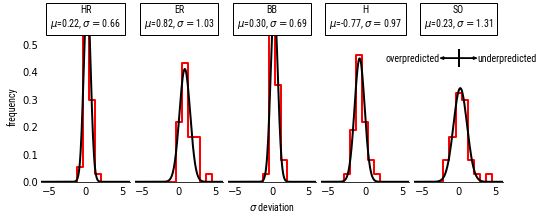

In [9]:

# keep only the players that we were able to construct predictions for
goodsig = siglist[(np.sum(siglist,axis=1)>0.) & (np.nanmax(np.abs(siglist),axis=1)<7.)]

fig = plt.figure(figsize=(7,3))

PDict = {}
for istat,stat in enumerate(stattest):

    dx = 0.175
    xstart = istat*(dx+0.01)+0.06
    ax = fig.add_axes([xstart,0.2,dx,0.7])

    a,b = np.histogram(goodsig[:,istat],bins=np.linspace(-7.,7.,18))

    popt, pcov = curve_fit(gaussian,b[0:-1]+0.5*(b[1]-b[0]),a/np.sum(a))
    print('Mean=',popt[1],'Sigma=',popt[2])

    ax.plot(b[0:-1]+0.5*(b[1]-b[0]),a/np.sum(a),color='red',drawstyle='steps-mid')

    xvals = np.linspace(b[0]+0.5*(b[1]-b[0]),b[-1]+0.5*(b[1]-b[0]),200)
    ax.plot(xvals,gaussian(xvals,*popt),color='black')

    ax.text(0.,0.55,'{0}\n$\mu$={1:3.2f}, $\sigma=${2:3.2f}'.format(stat,popt[1],np.abs(popt[2])),\
            color='black',ha='center',va='bottom',bbox=dict(facecolor='white', alpha=1.0),size=8, fontproperties=prop)

    if istat==2:
        ax.set_xlabel('$\sigma$ deviation',size=12, fontproperties=prop)
        
    if istat==0:
        ax.set_ylabel('frequency',size=12, fontproperties=prop)
    else:
        ax.set_yticklabels(())
        
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    ax.axis([-6.,6.,0.,0.55])

ax.arrow(0.,0.45,2.,0.,width=0.0005,head_width=0.01,head_length=0.5)
ax.arrow(0.,0.45,-2.,0.,width=0.0005,head_width=0.01,head_length=0.5)
ax.plot([0.,0.],[0.42,0.48],color='black')
ax.text(2.6,0.45,'underpredicted',ha='left',va='center',size=8, fontproperties=prop)
ax.text(-2.6,0.45,'overpredicted',ha='right',va='center',size=8, fontproperties=prop)




## Part 2: Hitters

In [10]:
# definitions to match the results

def match_hitting_results(pl,RealStats,ProjectedStats,norm=True):
    '''match the results from the hitting year, return sigmas
    
    certain categories must match in name...
    '''
    plr = np.where(RealStats['Name']==pl)[0][0]
    plp = np.where(np.array([x.decode().rstrip() for x in ProjectedStats['Name']])==pl)[0][0]

    compstats = ['AVG','HR','R','RBI','SB']
    
    sigmas = np.zeros(len(compstats))
    
    if norm:
        for istat,stat in enumerate(compstats):
            if stat =='AVG':
                sigmas[istat] = (float(RealStats[stat][plr])-float(ProjectedStats[stat][plp]))/float(ProjectedStats['e'+stat][plp])
            else:

                sigmas[istat] = (float(RealStats[stat][plr])/float(RealStats['PA'][plr])\
                             -float(ProjectedStats[stat][plp])/float(ProjectedStats['PA'][plp]))\
            /(float(ProjectedStats['e'+stat][plp])/float(ProjectedStats['PA'][plp]))
        
        
    else:
        for istat,stat in enumerate(compstats):
            sigmas[istat] = (float(RealStats[stat][plr])-float(ProjectedStats[stat][plp]))/float(ProjectedStats['e'+stat][plp])
        
        
        
    return sigmas
    





In [11]:

nplayers = len(BattingProjections2019['Name'])
sigma_stats = np.zeros([nplayers,5])

for pl in range(0,nplayers):

    try:
        sigmas = match_hitting_results(BattingProjections2019['Name'][pl].decode().rstrip(),Batting2019,BattingProjections2019)
        sigma_stats[pl] = np.array(sigmas)
    except:
        #print('Failed for ',BattingProjections2019['Name'][pl].decode().rstrip())
        sigma_stats[pl] = np.array([np.nan,np.nan,np.nan,np.nan,np.nan])


Mean= -0.2048679016009909 Sigma= 1.2595025425713275
Mean= 0.8672107001570499 Sigma= 2.890291834684957
Mean= 0.6800907829704115 Sigma= 2.8155494598715984
Mean= 0.8576046168148783 Sigma= 2.800788585126059
Mean= -0.5474152875994506 Sigma= 1.8822309311534993


Text(-2.6, 0.4, 'overpredicted')

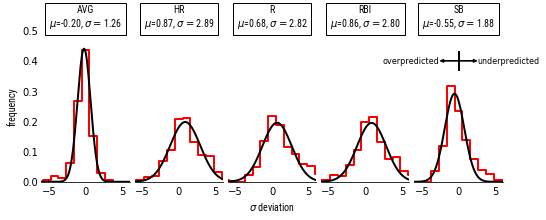

In [12]:
# how can we check the uncertainties?
# check how many sigma off we are on average

stats = ['AVG','HR','R','RBI','SB']




fig = plt.figure(figsize=(7,3))

PDict = {}
for istat,stat in enumerate(stats):

    dx = 0.175
    xstart = istat*(dx+0.01)+0.06
    ax = fig.add_axes([xstart,0.2,dx,0.7])

    a,b = np.histogram(sigma_stats[:,istat],bins=np.linspace(-9.,9.,18))

    popt, pcov = curve_fit(gaussian,b[0:-1]+0.5*(b[1]-b[0]),a/np.sum(a))
    print('Mean=',popt[1],'Sigma=',popt[2])

    ax.plot(b[0:-1]+0.5*(b[1]-b[0]),a/np.sum(a),color='red',drawstyle='steps-mid')

    xvals = np.linspace(b[0]+0.5*(b[1]-b[0]),b[-1]+0.5*(b[1]-b[0]),200)
    ax.plot(xvals,gaussian(xvals,*popt),color='black')

    ax.text(0.,0.5,'{0}\n$\mu$={1:3.2f}, $\sigma=${2:3.2f}'.format(stat,popt[1],popt[2]),\
            color='black',ha='center',va='bottom',bbox=dict(facecolor='white', alpha=1.0),size=8, fontproperties=prop)

    if istat==2:
        ax.set_xlabel('$\sigma$ deviation',size=12, fontproperties=prop)
        
    if istat==0:
        ax.set_ylabel('frequency',size=12, fontproperties=prop)
    else:
        ax.set_yticklabels(())
        
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    ax.axis([-6.,6.,0.,0.5])

ax.arrow(0.,0.4,2.,0.,width=0.0005,head_width=0.01,head_length=0.5)
ax.arrow(0.,0.4,-2.,0.,width=0.0005,head_width=0.01,head_length=0.5)
ax.plot([0.,0.],[0.37,0.43],color='black')
ax.text(2.6,0.4,'underpredicted',ha='left',va='center',size=8)
ax.text(-2.6,0.4,'overpredicted',ha='right',va='center',size=8)


#plt.savefig('/Users/mpetersen/Desktop/battingpredictions.png',dpi=300)